# Structured Neural Networks

In this homework, we train a collection of neural networks including a convolutional neural network on the MNIST dataset, and a graph neural network on some graph classification task.

In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import utils
import numpy

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

We first consider the convolutional neural network, which we apply in the following to the MNIST data.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

Xr,Tr = trainset.data.float().view(-1,1,28,28)/127.5-1,trainset.targets
Xt,Tt = testset.data.float().view(-1,1,28,28)/127.5-1,testset.targets

We consider for this dataset a convolution network made of four convolutions and two pooling layers.

In [3]:
torch.manual_seed(0)
cnn = utils.NNClassifier(nn.Sequential(
    nn.Conv2d( 1, 8, 5), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d( 8, 24, 5), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d( 24, 72, 4), nn.ReLU(),
    nn.Conv2d( 72, 10, 1)
))

The network is wrapped in the class `utils.NNClassifier`, which exposes scikit-learn-like functions such as `fit()` and `predict()`. To evaluate the convolutional neural network, we also consider two simpler baselines: a one-layer linear network, and standard fully-connected network composed of two layers.

In [4]:
torch.manual_seed(0)
lin = utils.NNClassifier(nn.Sequential(nn.Linear(784, 10)),flat=True)

torch.manual_seed(0)
fc = utils.NNClassifier(nn.Sequential(
    nn.Linear( 784, 512), nn.ReLU(), nn.Linear( 512, 10)
),flat=True)

### Evaluating the convolutional neural network (15 P)

We now proceed with the comparision of these three classifiers.

**Task:**

 * **Train each classifier for 5 epochs and print the classification accuracy on the training and test data (i.e. the fraction of the examples that are correctly classified). To avoid running out of memory, predict the training and test accuracy only based on the 2500 first examples of the training and test set respectively.**

In [5]:
for name,cl in [('linear',lin),('full',fc),('conv',cnn)]:

    # ------------------------------------
    # TODO: Replace by your code
    # ------------------------------------
    import solutions
    errtr,errtt = solutions.analyze(cl,Xr,Tr,Xt,Tt)
    # ------------------------------------
    
    print('%10s train: %.3f  test: %.3f'%(name,errtr,errtt))

    linear train: 0.910  test: 0.878
      full train: 0.968  test: 0.952
      conv train: 0.989  test: 0.983


We observe that the convolutional neural network reaches the higest accuracy with less than 2% of misclassified digits on the test data.

### Confidently predicted digits (15 P)

We now ask whether some digits are easier to predict than others for the convolutional neural network. For this, we observe that the neural network produces at its output scores $y_c$ for each class $c$. These scores can be converted to a class probability using the *softargmax* (also called *softmax*) function:

$$
p_c = \frac{\exp(y_c)}{\sum_{c'=1}^{10} \exp(y_{c'})}
$$

**Task:**

 * **Find for the convolutional network the data points in the test set that are predicted with the highest probability (the lowest being random guessing). To avoid numerical unstability, your implementation should work in the log-probability domain and make use of numerically stable functions of numpy/scipy such as logsumexp.**

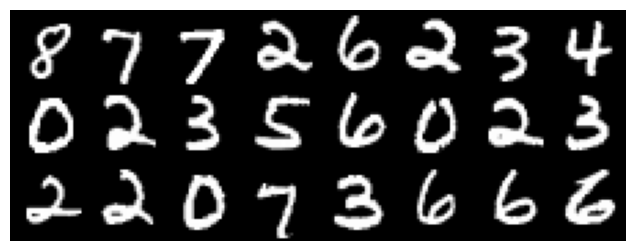

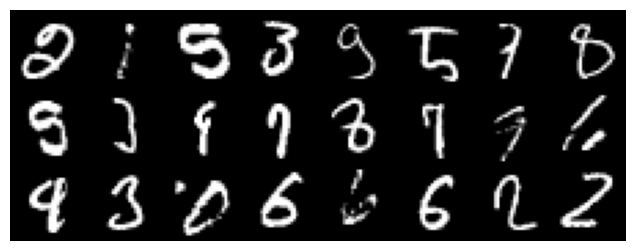

In [6]:
# ------------------------------------
# TODO: Replace by your code
# ------------------------------------
import solutions
highest,lowest = solutions.highestlowest(cnn,Xt)
# ------------------------------------

for digits in [highest,lowest]:
    plt.figure(figsize=(8,3))
    plt.axis('off')
    plt.imshow(digits.numpy().reshape(3,8,28,28).transpose(0,2,1,3).reshape(28*3,28*8),cmap='gray')
    plt.show()

We observe that the most confident digits are thick and prototypical. Interestingly, the highest confidence digits are all from the class "3". The low-confidence digits are on the other hand thiner, and are often also more difficult to predict for a human.

### Graph Neural Network (20 P)

We consider a graph neural network (GNN) that takes as input graphs of size $m$ given by their adjacency matrix $A$ and which is composed of the following four layers:

\begin{align*}
H_0 &= U\\
H_1 &= \rho(\Lambda H_0 W)\\
H_2 &= \rho(\Lambda H_1 W)\\
H_3 &= \rho(\Lambda H_2 W)\\
y &= \boldsymbol{1}^\top H_{3} V
\end{align*}

$U$ is a matrix of size $m \times h$, $W$ is a matrix of size $h \times h$, $V$ is a matrix of size $h \times 3$ and $\Lambda$ is the normalized Laplacian associated to the graph adjacency matrix $A$ (i.e. $\Lambda = D^{-0.5} A D^{-0.5}$ where $D$ is a diagonal matrix containing the degree of each node), and $\rho(t) = \max(0,t)$ is the rectified linear unit that applies element-wise.

**Task:**

 * **Implement the forward function of the GNN. It should take as input a minibatch of adjacency matrices $A$ (given as a 3-dimensional tensor of dimensions (minibatch_size $\times$ number_nodes $\times$ number_nodes)) and return a matrix of size minibatch_size $\times$ 3 representing the scores for each example and predicted class.**
 
*(Note: in your implementation use array operations instead of looping over all individual examples of the minibatch.)*

In [7]:
class GNN(torch.nn.Module):
    
    def __init__(self,nbnodes,nbhid,nbclasses):
        torch.nn.Module.__init__(self)
        self.m = nbnodes
        self.h = nbhid
        self.c = nbclasses

        self.U = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,nbnodes**-.5,[nbnodes,nbhid])))
        self.W = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,nbhid**-.5,[nbhid,nbhid])))
        self.V = torch.nn.Parameter(torch.zeros([nbhid,nbclasses]))
    
    def forward(self,A):
        # ------------------------------------
        # TODO: Replace by your code
        # ------------------------------------
        import solutions
        Y = solutions.forward(self,A)
        # ------------------------------------
         
        return Y

The graph neural network is now tested on a simple graph classification task where the three classes correspond to star-shaped, chain-shaped and random-shaped graphs. Because the GNN is more difficult to optimize and the dataset is smaller, we train the network for 500 epochs. We compare the GNN with a simple fully-connected network built directly on the adjacency matrix.

In [8]:
Ar,Tr,At,Tt = utils.graphdata()

torch.manual_seed(0)
dnn = utils.NNClassifier(nn.Sequential(nn.Linear( 225,512), nn.ReLU(),nn.Linear(512,3)),flat=True)
torch.manual_seed(0)
gnn = utils.NNClassifier(GNN(15,25,3))

for name,net in [('DNN',dnn),('GNN',gnn)]:
    net.fit(Ar,Tr,lr=0.01,epochs=500)
    Yr = net.predict(Ar)
    Yt = net.predict(At)
    acctr = (Yr.max(dim=1)[1] == Tr).data.numpy().mean()
    acctt = (Yt.max(dim=1)[1] == Tt).data.numpy().mean()
    print('name: %10s  train: %.3f  test: %.3f'%(name,acctr,acctt))

name:        DNN  train: 1.000  test: 0.829
name:        GNN  train: 1.000  test: 0.968


We observe that both networks are able to perfectly classify the training data, however, due to its particular structure, the graph neural network generalizes better to new data points.